# Tree Census Final Project

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats

## Exlporatory Data Analysis and Visualization

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

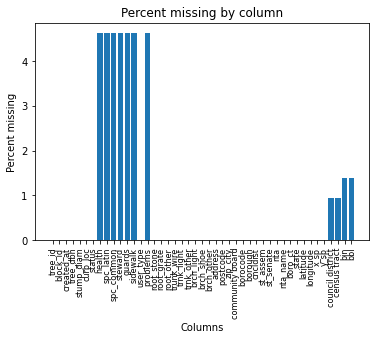

In [4]:
# plot missing values by columns
vals = (tree_df.isna().sum() * 100 / len(tree_df)).values
keys = tree_df.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column")
plt.show()

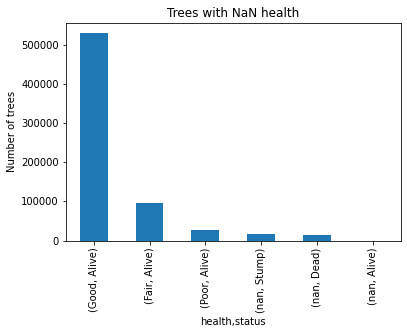

In [5]:
# plot NA values by health status
tree_df[['health', 'status']].value_counts(dropna=False).plot(kind='bar')
plt.title('Trees with NaN health')
plt.ylabel("Number of trees")
plt.show()

In [6]:
# drop dead trees that appear as NA
tree_df_clean = tree_df[tree_df['health'].notna()]
print("Dead or stumps:", tree_df.shape[0] - tree_df_clean.shape[0])

Dead or stumps: 31616


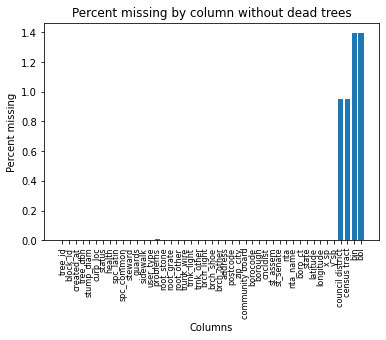

In [7]:
# other NA values
vals = (tree_df_clean.isna().sum() * 100 / len(tree_df_clean)).values
keys = tree_df_clean.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column without dead trees")
plt.show()

In [8]:
'''
Dropped columns:
- borocode and boro_ct, equivalent to borough
- x_sp and y_sp - use latitude and longitude instead
- state - identical for all
- nta_name, equivalent to nta
- zip_city, directly correlated to postcode
- address, estimated from latitude and longitude
- spc_latin, equivalent to spc_common
- created_at, not helpful (time data was added)
- tree_id, not helpful (unique identifier)
- block_id, not helpful (geo location)
- user_type, not helpful (which volunteer analyzed it)
- bin, not helpful (building identifier)
- bbl, not helpful (block identifier)
- council district, equivalent to cncldist
- census tract, missing values and other location data
- problems, one-hot encoded in other values
- status, all are alive after dropping dead and stumps
- stump_diam, only applies to stumps
'''
tree_df_dropped = tree_df_clean.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam'
])

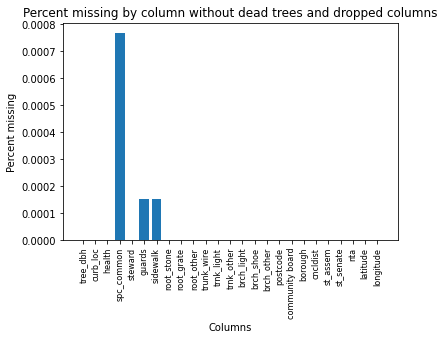

In [9]:
# remianing NA values
vals = (tree_df_dropped.isna().sum() * 100 / len(tree_df_dropped)).values
keys = tree_df_dropped.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column without dead trees and dropped columns")
plt.show()

In [10]:
# drop those rows since so few missing
tree_df_processed = tree_df_dropped.dropna(how='any')
print("Trees with missing values:", tree_df_dropped.shape[0] - tree_df_processed.shape[0])
miss_val = tree_df_processed.shape[0]

Trees with missing values: 6


In [11]:
# drop invalid zipcode
tree_df_processed = tree_df_processed[tree_df_processed['postcode'] != 83]

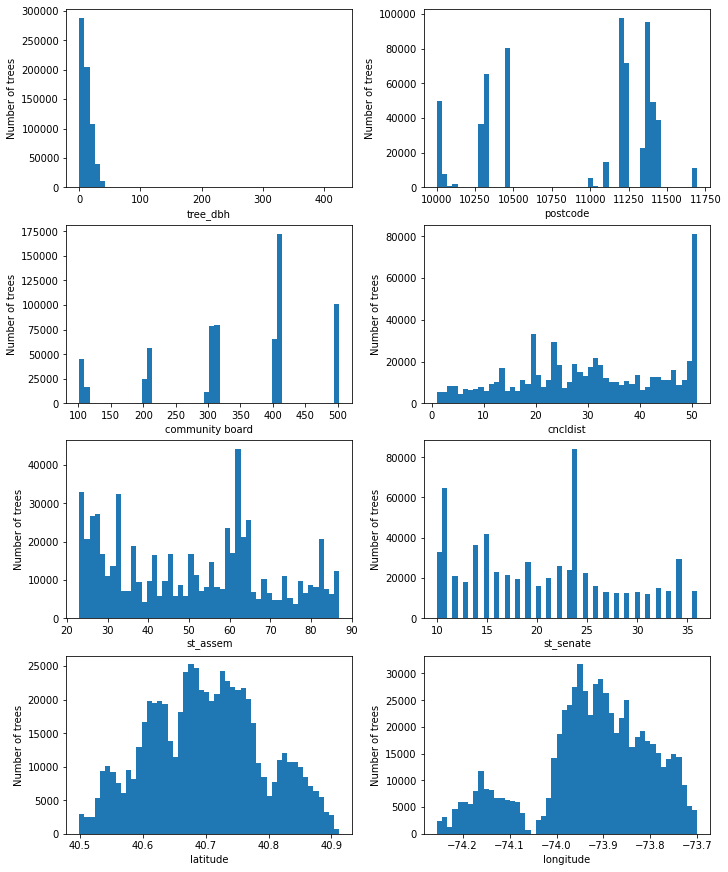

In [12]:
# plot each quantitaive feature
vals = [
    'tree_dbh', 'postcode', 'community board', 'cncldist', 'st_assem',
    'st_senate', 'latitude', 'longitude'
]

fig, axs = plt.subplots(len(vals) // 2, 2, figsize=(10, 12), constrained_layout=True)

for i, val in enumerate(vals):
    axs[i // 2, i % 2].hist(tree_df_processed[val], bins=50)
    axs[i // 2, i % 2].set(xlabel=val, ylabel="Number of trees")

plt.show()

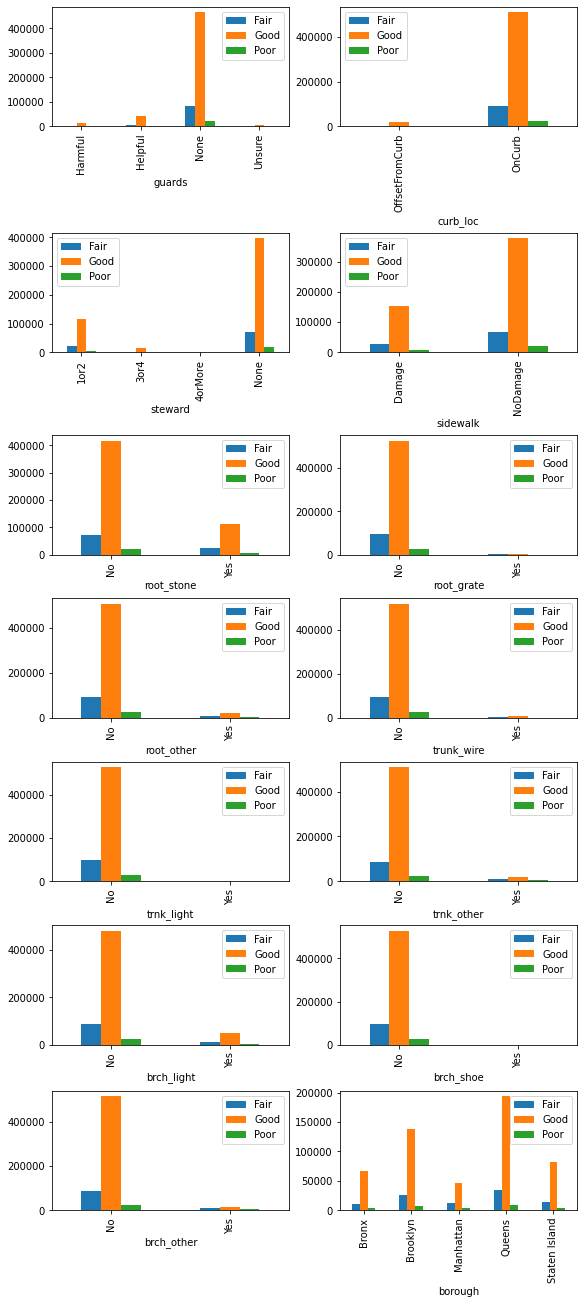

In [13]:
# plot each categorical feature realtive to the health of the tree
def cat_plot(feature, ax):
    df = tree_df_processed[['health', feature]].value_counts().to_frame()
    df = df.unstack(level=0)
    df.columns = ['Fair', 'Good', 'Poor']
    df.plot(kind='bar', ax=ax)

vals = [
    'guards', 'curb_loc', 'steward', 'sidewalk', 'root_stone', 'root_grate',
    'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe',
    'brch_other', 'borough'
]
    
fig, axs = plt.subplots(len(vals) // 2, 2, figsize=(8, 18), constrained_layout=True)

for i, val in enumerate(vals):
    cat_plot(val, axs[i // 2, i % 2])

plt.show()

/var/folders/zj/3m9wgzks749byc9nmxvl8xsr0000gn/T/ipykernel_46563/2713682378.py:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = tree_df_encoded.corr()


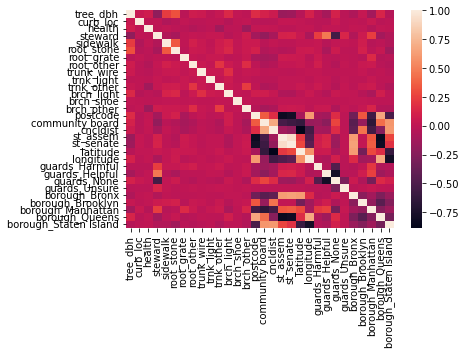

In [14]:
# look for multicolinearity
# Ordinal encoding
tree_df_encoded = tree_df_processed.copy(deep=True)

health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df_encoded['health'] = enc.fit_transform(tree_df_processed[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df_encoded['steward'] = enc.fit_transform(tree_df_encoded[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df_encoded['sidewalk'] = enc.fit_transform(tree_df_encoded[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df_encoded['curb_loc'] = enc.fit_transform(tree_df_encoded[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df_encoded[feat] = enc.fit_transform(tree_df_encoded[[feat]])
    
# One-hot encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df_encoded[['guards']])
tree_df_encoded['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df_encoded = tree_df_encoded.drop(columns=['guards'])

guards = enc.fit_transform(tree_df_encoded[['borough']])
tree_df_encoded['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df_encoded = tree_df_encoded.drop(columns=['borough'])

corr = tree_df_encoded.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

 we can see here the location variables are highly correlated, we can drop them in preprocessing

In [15]:
# check species feature for usability
tree_df_encoded['spc_common'].value_counts()

London planetree          86960
honeylocust               64254
Callery pear              58928
pin oak                   52971
Norway maple              34189
littleleaf linden         29692
cherry                    29279
Japanese zelkova          29209
ginkgo                    20925
Sophora                   19336
red maple                 17246
green ash                 16250
American linden           13530
silver maple              12277
sweetgum                  10657
northern red oak           8399
silver linden              7995
American elm               7528
maple                      7080
purple-leaf plum           6879
swamp white oak            6598
crimson king maple         5923
Chinese elm                5342
'Schubert' chokecherry     4888
Japanese tree lilac        4568
eastern redbud             3801
golden raintree            3719
crab apple                 3527
Kentucky coffeetree        3364
willow oak                 3184
dawn redwood               3020
hawthorn

we can see that there are too many species to make use of, so we can drop them in the preprocessing

## Preprocessing

In [ ]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [ ]:
# drop columns that arent useful, or suffer from multicolinearity
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

In [ ]:
# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [ ]:
# scale diameters (only continuos numerical feature left)
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

In [ ]:
# Ordinal Encode (categorical hierarchal features)
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode (non-hierarchal categorical features)
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [ ]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [ ]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [ ]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [ ]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [ ]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## Logistic Regression

## Decision Tree

In [ ]:
# function to evaluate the model
def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)  
    
    # accuracy scores
    acc_train = accuracy_score(y_train,y_train_predict)
    acc_test = accuracy_score(y_test,y_test_predict)
    
    # print training and testing accuracy
    print("Accuracy of Training data: ", acc_train)
    print("Accuracy of Testing data: ", acc_test)
    
    # print train and test f1 score
    f1_train = f1_score(y_train, y_train_predict , average='weighted')
    f1_test = f1_score(y_test, y_test_predict , average='weighted')
    print("weigted f1 of Training data: ", f1_train)
    print("weigted f1 of Testing data: ", f1_test)

    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()

In [ ]:
# function to fit and tune the model
def dt_select(x_train,y_train,score):
    # possible values for the model to be tuned on
    param_grid = {
        'max_depth': [4,8,10,12,15,20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features":["log2","sqrt",None],
        "max_leaf_nodes": [None,10,20,30],
        'ccp_alpha' : np.logspace(-6, -4, 3)
    }
    
    # create a base model
    dt = DecisionTreeClassifier(random_state=100)

    # initantiate the random search model based on parameters defined above
    randomized_search = RandomizedSearchCV(estimator = dt, param_distributions = param_grid, scoring=score,cv=5)

    randomized_model=randomized_search.fit(x_train,y_train)
    return randomized_model

In [ ]:
# random stratified sampling
# accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("validation accuracy score", random_best.best_score_)
print("test accuracy score",random_best.score(x_test,y_test))
print("test accuracy score",random_best.score(x_train,y_train))
print("test f1 score",random_best.f1_score(x_train,y_train))

#accuracy as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

#f1 as scoring metric
random_best_f1 = dt_select(x_train,y_train,'f1_macro')
print("optimal hyperparameters",random_best_f1.best_params_)
print("optimal f1 score", random_best_f1.best_score_)
print("test f1 score",random_best_f1.score(x_test,y_test))

#f1 as metric for hyperparamter tuning
model_result(random_best_f1, x_train, y_train, x_test, y_test)

# accuracy as scoring metric
random_best = dt_select(x_train,y_train,'recall_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal accuracy score", random_best.best_score_)
print("test accuracy score",random_best.score(x_test,y_test))
print("test accuracy score",random_best.score(x_train,y_train))
print("test accuracy score",random_best.f1_score(x_train,y_train))

#accuracy as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

In [ ]:
# random over sampling
# accuracy as scoring metric
over_best = dt_select(x_ros, y_ros,'accuracy')
print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
print("test accuracy",over_best.score(x_test,y_test))

# accuracy as metric for hyperparamter tuning
model_result(over_best, x_ros, y_ros, x_test, y_test)

# f1 as score metric
over_best_f1 = dt_select(x_ros, y_ros,'f1_macro')
print("optimal hyperparameters",over_best_f1.best_params_)
print("optimal accuracy score", over_best_f1.best_score_)
print("test accuracy",over_best_f1.score(x_test,y_test))

#f1 as metric for hyperparamter tuning
model_result(over_best_f1, x_ros, y_ros, x_test, y_test)

In [ ]:
# random under sampling
# accuracy as scoring metric
under_best = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)
print("test accuracy",under_best.score(x_test,y_test))

# accuracy as metric for hyperparamter tuning
model_result(under_best, x_rus, y_rus, x_test, y_test)

# f1 as score metric
under_best_f1 = dt_select(x_rus, y_rus,'f1_macro')
print("optimal hyperparameters",under_best_f1.best_params_)
print("optimal f1 score", under_best_f1.best_score_)
print("test f1 score",under_best_f1.score(x_test,y_test))

# f1 as metric for hyperparamter pruning
model_result(under_best_f1, x_rus, y_rus, x_test, y_test)

In [ ]:
# smote sampling
# accuracy as metric
smote_best = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))

# accuracy as metric for hyperparamter pruning
model_result(smote_best, x_smote, y_smote, x_test, y_test)

# f1 sccore as metric
smote_best_f1 = dt_select(x_smote, y_smote,'f1_macro')
print("optimal hyperparameters",smote_best_f1.best_params_)
print("optimal f1 score", smote_best_f1.best_score_)
print("test f1 score",smote_best_f1.score(x_test,y_test))

# f1 as metric for hyperparamter pruning
model_result(smote_best_f1, x_smote, y_smote, x_test, y_test)

## Support Vector Machine

In [ ]:
# model evaluation function
def SVM_result(model, X_train, y_train, X_test, y_test, report = False):
    # predict y
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)    
    # accuracy scores
    acc_predit_train = accuracy_score(y_train_predict,y_train)
    acc_predit_test = accuracy_score(y_test_predict,y_test)
    # print trainind and testing accuracy
    print("Accuracy of Training data: ", acc_predit_train)
    print("Accuracy of Testing data: ", acc_predit_test)
    
    # show result report
    if (report):
        print(classification_report(y_test, y_test_predict))
        
    # show confusion_matrix
    cf = confusion_matrix(y_test, y_test_predict)
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()

In [ ]:
# base SVM model
svm = SVC(random_state=100)

# random search for hyperparameter tuning
param_list = {'C': stats.uniform(0, 5), 
              'kernel': ['linear', 'rbf'], 
              'gamma': [.01, 1, 10, 100]}

rand_search_ac = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    scoring = 'accuracy'
                                    random_state = 2022) 

rand_search_f1 = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    scoring = 'f1_macro',
                                    random_state = 2022) 

rand_search_recall = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    scoring = 'recall_macro',
                                    random_state = 2022) 

In [ ]:
# Hyperparameter tuning random stratified sampling
# accuracy as scoring metric
rand_search_ac.fit(x_train, y_train) 
svm_best = rand_search_ac.best_estimator_
print(svm_best)
SVM_result(svm_best, x_train, y_train, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_train, y_train) 
svm_best = rand_search_f1.best_estimator_
print(svm_best)
SVM_result(svm_best, x_train, y_train, x_test, y_test)

In [ ]:
# Hyperparameter tuning under sampling
# accuracy as scoring metric
rand_search_ac.fit(x_rus, y_rus) 
svm_best = rand_search_ac.best_estimator_
print(svm_best)
SVM_result(svm_best, x_rus, y_rus, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_rus, y_rus) 
svm_best = rand_search_f1.best_estimator_
print(svm_best)
SVM_result(svm_best, x_rus, y_rus, x_test, y_test)

In [ ]:
# Hyperparameter tuning over sampling
# accuracy as scoring metric
rand_search_ac.fit(x_ros, y_ros) 
svm_best = rand_search_ac.best_estimator_
print(svm_best)
SVM_result(svm_best, x_ros, y_ros, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_ros, y_ros) 
svm_best = rand_search_f1.best_estimator_
print(svm_best)
SVM_result(svm_best, x_ros, y_ros, x_test, y_test)

In [ ]:
# Hyperparameter tuning smote
# accuracy as scoring metric
rand_search_ac.fit(x_smote, y_smote) 
svm_best = rand_search_ac.best_estimator_
print(svm_best)
SVM_result(svm_best, x_smote, y_smote, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_smote, y_smote) 
svm_best = rand_search_f1.best_estimator_
print(svm_best)
SVM_result(svm_best, x_smote, y_smote, x_test, y_test)

## Tal